In [1]:
#!/usr/bin/env python3
from mpl_toolkits.mplot3d import Axes3D
import math as m
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from sklearn.model_selection import train_test_split, KFold
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import seaborn as sns

/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2>Part A<h2>

2500


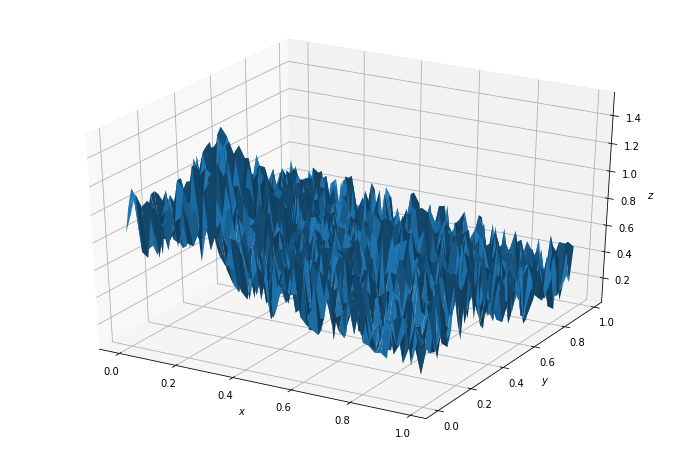

In [2]:
# add one with the noize and one without 

#target function in z (surface)
#PART A
def FrankeFunction(x,y):
    #evaluation of each term
    term1 = 0.75*np.exp(-(0.25+(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

#make boundaries and linspace in x and y
x = np.arange(0, 1, 0.02)
y = x
#meshgrid for plotting in 3D. also helpful for the Xmatrix computation
X, Y = np.meshgrid(x,y)
Z = FrankeFunction(X,Y)
#correction doing normalization and adding noise on the Z value
Z = Z + 0.5*np.random.rand(Z.shape[0],Z.shape[1])

#plot
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.savefig('franke_noise.png')

In [3]:
#X matrix design function
def var_matrix(x_points, y_points, deg):
    #reacomodating the shape of the input into a 1D array
    x_points = x_points.reshape(x_points.shape[0]*x_points.shape[1],1)
    y_points = y_points.reshape(y_points.shape[0]*y_points.shape[1],1)
    
    #Not necessary but just in case, here is the formula
    pos = m.factorial(deg+2)/(m.factorial(deg)*m.factorial(2))
    #creation of return matrix with first column of intercepts
    X = np.zeros((len(x_points),1))
    X[:,0] = 1.0
    
    #In these loops the pos variable is implicitly named here
    for i in range(1,deg+1):
        for j in range(i+1):
        
            #Stacking polinomial terms in the columns of the X matrix
            X = np.hstack((X, ((x_points**(j)) * (y_points**(i-j)))))
    
    return X

In [4]:
#functions for error
#R2
def R2(z_data,z_model):
    return 1- np.sum((z_data - z_model)**2.0) / np.sum((z_data - np.mean(z_data))**2.0)

#Mean Square Error
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum(((z_data-z_model)**2.0)) / n

#Bias confidence interval
def conf_int(inv_X, conf, betas):
    inter = []
    men = np.mean(inv_X.diagonal())
    s = np.sqrt(np.sum((inv_X.diagonal() - men)**2))
    for i in range(len(betas)):
        inter.append([betas[i]-conf*s, betas[i]+conf*s])
    return np.asarray(inter)

<h2>Part A<h2>

2500


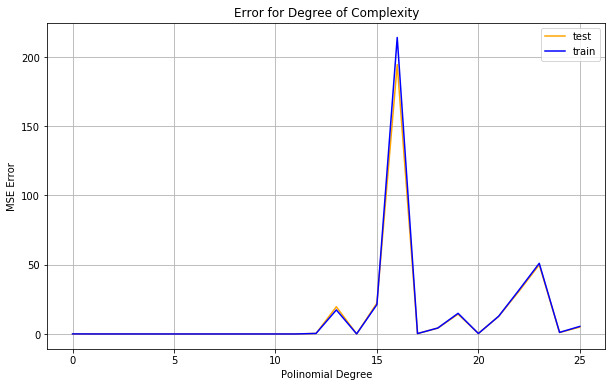

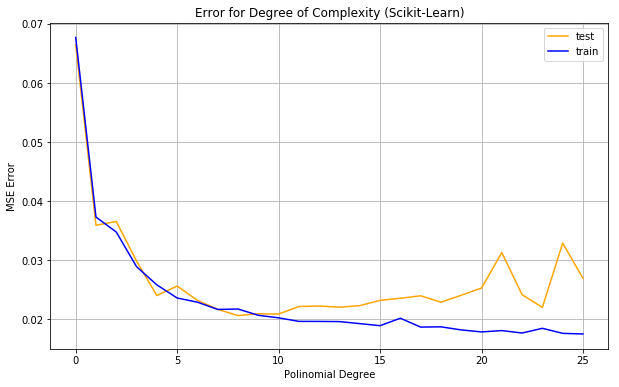

In [88]:
#Variables for saving the errors while changing the complexity of the model (polinomial degree)
#This is point A and part of point B (bias-variance trade-off dependent on complexity)
er_R2 = []
er_MSE = []

tr_R2 = []
tr_MSE = []
#variable that determines the maximum polinomial degree to test
degree = 25
input_z = Z.reshape(Z.shape[0]*Z.shape[1])

for k in range(degree+1):
    #doing the polynomial fit by using the Moore-Penrose matrix inversion
    Xm = var_matrix(X,Y,k)
    #random data_test split
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size=0.2)
    inverse = np.linalg.pinv(X_train.T @ X_train)
    #adding the confidence intervals
    beta = inverse @ X_train.T @ Z_train
    inter = conf_int(inverse, 1.654, beta)
    #print('Confidence interval for degree', k, '=')
    #generating based on the model predictions with the train data set and the test dataset
    Z_model = X_test @ beta
    Ztr_model = X_train @ beta
    #saving performance error
    tr_R2.append(R2(Z_train, Ztr_model))
    tr_MSE.append(MSE(Z_train, Ztr_model))
    er_R2.append(R2(Z_test,Z_model))
    er_MSE.append(MSE(Z_test,Z_model))
    
#plot of error
print(len(input_z))
plt.figure(figsize=(10,6))
plt.plot(range(degree+1),er_MSE, label='test', color='orange')
plt.plot(range(degree+1),tr_MSE, label = 'train', color='blue')
plt.grid()
plt.legend()
plt.xlabel('Polinomial Degree')
plt.ylabel('MSE Error')
plt.title('Error for Degree of Complexity')
plt.savefig('OLS_compl.png')

#Renew the variables for Sklearn regression, OLS
er_R2 = []
er_MSE = []

tr_R2 = []
tr_MSE = []
    
for k in range(degree+1):
    #doing the polynomial fit by using the Moore-Penrose matrix inversion
    Xm = var_matrix(X,Y,k)
    #random data_test split
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size=0.2)
    #everything works the same
    reg = LinearRegression().fit(X_train,Z_train)
    #generating based on the model predictions with the train data set and the test dataset
    Z_model = reg.predict(X_test)
    Ztr_model = reg.predict(X_train)
    #print(reg.coef_)
    #saving performance error
    tr_R2.append(R2(Z_train, Ztr_model))
    tr_MSE.append(MSE(Z_train, Ztr_model))
    er_R2.append(R2(Z_test,Z_model))
    er_MSE.append(MSE(Z_test,Z_model))
    

#plot of error
plt.figure(figsize=(10,6))
plt.plot(range(degree+1),er_MSE, label='test', color='orange')
plt.plot(range(degree+1),tr_MSE, label = 'train', color='blue')
plt.grid()
plt.legend()
plt.xlabel('Polinomial Degree')
plt.ylabel('MSE Error')
plt.title('Error for Degree of Complexity (Scikit-Learn)')
plt.savefig('OLS_compl_sklearn.png')

<h2>Part B<h2>

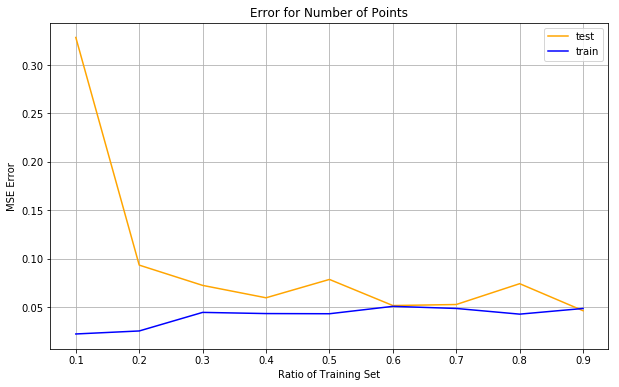

In [84]:
#Bias and variance trade-off as function of number of data points
#Lets fix the polinomial degree to 5
er_R2 = []
er_MSE = []

tr_R2 = []
tr_MSE = []
#variable that determines the maximum polinomial degree to test
degree = 5
tr_perc = np.arange(0.1,1,0.1)

#loop, this time in percentage of data. From 0.1 train - 0.9 test to 0.9 train - 0.1 test
for k in range(len(tr_perc)):
    #doing the polynomial fit by using the Moore-Penrose matrix inversion    
    Xm = var_matrix(X,Y,degree)
    input_z = Z.reshape(Z.shape[0]*Z.shape[1])
    #random data_test split
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size= 1-tr_perc[k])
    inverse = np.linalg.pinv(X_train.T @ X_train)
    #interval.append(inter[1] - inter[0])
    beta = inverse @ X_train.T @ Z_train
    #inter = conf_int(inverse, 1.654)
    #print('Confidence interval for degree', k, '=', inter)
    Z_model = X_test @ beta
    Ztr_model = X_train @ beta
    tr_R2.append(R2(Z_train, Ztr_model))
    tr_MSE.append(MSE(Z_train, Ztr_model))
    er_R2.append(R2(Z_test,Z_model))
    er_MSE.append(MSE(Z_test,Z_model))

#plot of error
plt.figure(figsize=(10,6))
plt.plot(tr_perc,er_MSE, label='test', color='orange')
plt.plot(tr_perc,tr_MSE, label = 'train', color='blue')
#plt.plot(range(degree+1),er_R2)
#plt.plot(range(degree+1), interval)
plt.grid()
plt.legend()
plt.xlabel('Ratio of Training Set')
plt.ylabel('MSE Error')
plt.title('Error for Number of Points')
plt.savefig('MSE_train_ratio.png')

"\n#plot of error\nplt.figure(figsize=(10,6))\nplt.plot(range(degree+1),aver_MSE, label='test', color='orange')\nplt.plot(range(degree+1),avtr_MSE, label = 'train', color='blue')\nplt.yscale('log')\nplt.grid()\nplt.legend()\nplt.xlabel('Complexity Degree')\nplt.ylabel('MSE Error')\nplt.title('Error for Complexity Degree (Bootstrap) (Scikit-Learn)')\nplt.savefig('OSL_bootstrap_sklearn.png')"

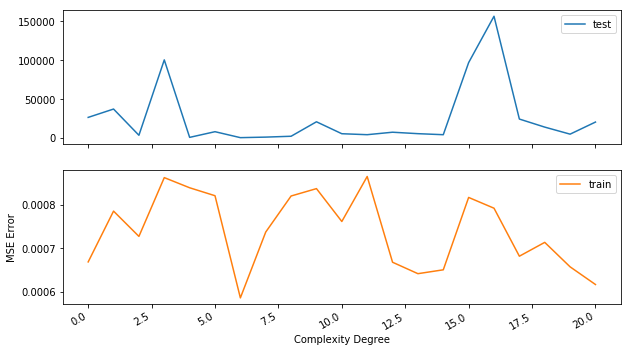

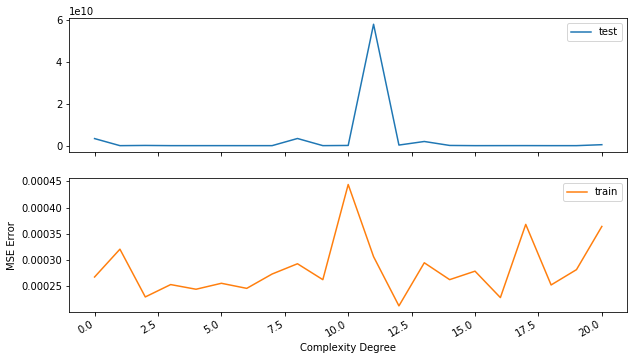

In [90]:
#Bootstrap and complexity degree (maximums)
degree = 20
boot = 500

#lists for saving the average errors of the Bootstraps
aver_MSE = []
aver_R2  = []
avtr_MSE = []
avtr_R2  = []

for d in range(degree+1):
    #Matrix design and Z values arrangement
    Xm = var_matrix(X,Y,degree)
    input_z = Z.reshape(Z.shape[0]*Z.shape[1])
    #data and test random split
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size= 0.2)
    #We could just equalize this to cero and take a division, but we don't want to move this (less memory consumption). LET IT BE
    er_MSE = []
    er_R2  = []
    tr_MSE = []
    tr_R2  = []
    
    for B in range(boot):
        #Takes random data for Train from the already Train dataset. Part of the data could be picked twice.
        numers  = np.random.randint(0,len(X_train),len(X_train))
        X_train = X_train[numers]
        Z_train = Z_train[numers]
        #inversion
        inverse = np.linalg.pinv(X_train.T @ X_train)
        #interval.append(inter[1] - inter[0])
        beta = inverse @ X_train.T @ Z_train
        #predictions with train and test
        Z_model = X_test @ beta
        Ztr_model = X_train @ beta
        tr_R2.append(R2(Z_train, Ztr_model))
        tr_MSE.append(MSE(Z_train, Ztr_model))
        er_R2.append(R2(Z_test,Z_model))
        er_MSE.append(MSE(Z_test,Z_model))
    
    #Taking the average of the bootstraps for a certain complexity and adding it to the list for further plotting
    aver_MSE.append(np.mean(er_MSE))
    aver_R2.append(np.mean(er_R2))
    avtr_MSE.append(np.mean(tr_MSE))
    avtr_R2.append(np.mean(tr_R2))

#plot
data = pd.DataFrame([aver_MSE, avtr_MSE]).T.rename(columns={0:'test',1:'train'})
#plt.title('Error for Complexity Degree (Bootstrap)')
data.plot(subplots=True,figsize=(10,6))
plt.ylabel('MSE Error')
plt.ylabel('MSE Error')
plt.xlabel('Complexity Degree')
#plt.yscale('log')
#plt.legend()
plt.savefig('OLS_bootstrap.png')



#Scikit-Learn
aver_MSE = []
aver_R2  = []
avtr_MSE = []
avtr_R2  = []

for d in range(degree+1):
    #Designing matrix X
    Xm = var_matrix(X,Y,degree)
    input_z = Z.reshape(Z.shape[0]*Z.shape[1])
    #split the data randomly
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size= 0.2)
    #we know, we know... again, sorry. Inefficient, bla bla bla...
    er_MSE = []
    er_R2  = []
    tr_MSE = []
    tr_R2  = []
    
    for B in range(boot):
        #Takes random data for Train from the already Train dataset. Part of the data could be picked twice.
        numers  = np.random.randint(0,len(X_train),len(X_train))
        X_train = X_train[numers]
        Z_train = Z_train[numers]
        #regression part
        reg = LinearRegression().fit(X_train, Z_train)
        #predictions with train and test sets
        Z_model = reg.predict(X_test)
        Ztr_model = reg.predict(X_train)
        tr_R2.append(R2(Z_train, Ztr_model))
        tr_MSE.append(MSE(Z_train, Ztr_model))
        er_R2.append(R2(Z_test,Z_model))
        er_MSE.append(MSE(Z_test,Z_model))
    
    #Taking the average of the bootstraps for a certain complexity and adding it to the list for further plotting
    aver_MSE.append(np.mean(er_MSE))
    aver_R2.append(np.mean(er_R2))
    avtr_MSE.append(np.mean(tr_MSE))
    avtr_R2.append(np.mean(tr_R2))

#plot and rearange the data
data = pd.DataFrame([aver_MSE, avtr_MSE]).T.rename(columns={0:'test',1:'train'})
#plt.title('Error for Complexity Degree (Bootstrap) (Scikit-Learn)')
data.plot(subplots=True,figsize=(10,6))
#plt.yscale('log')
#plt.legend()
plt.ylabel('MSE Error')
plt.ylabel('MSE Error')
plt.xlabel('Complexity Degree')
plt.savefig('OLS_bootstrap_sklearn.png')

<h2>Part C<h2>

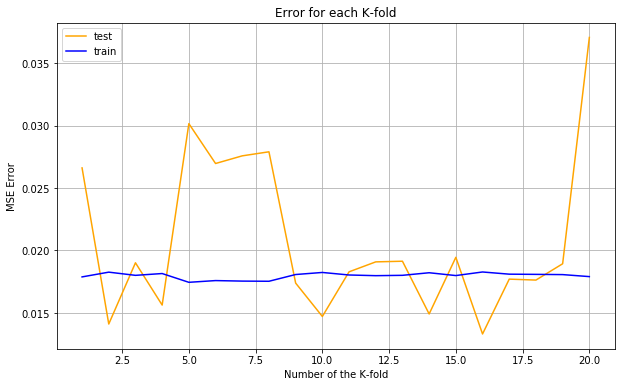

In [168]:
#K-Fold
#number of folds
K = 20
#polinomial degree
deg = 5
Xm = var_matrix(X,Y,deg)
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list
er_R2 = []
er_MSE = []

tr_R2 = []
tr_MSE = []

if len(Xm)%K == 0:
    #number of elements in a group for the K fold
    gr = int(len(Xm)/K)
    
    for k in range(K):
        #Prepare the test and train set
        rango = list(range(k*gr, gr*(k+1),1))
        X_test = Xm[k*gr: gr*(k+1)]
        Z_test = input_z[k*gr: gr*(k+1)]
        X_train = np.delete(Xm,rango, axis=0)
        Z_train = np.delete(input_z,rango, axis=0)
        #inversion
        inverse = np.linalg.pinv(X_train.T @ X_train)
        #inter = conf_int(inverse, 1.654)
        #interval.append(inter[1] - inter[0])
        beta = inverse @ X_train.T @ Z_train
        #print('Confidence interval for degree', k, '=', inter)
        Z_model = X_test @ beta
        Ztr_model = X_train @ beta
        tr_R2.append(R2(Z_train, Ztr_model))
        tr_MSE.append(MSE(Z_train, Ztr_model))
        er_R2.append(R2(Z_test,Z_model))
        er_MSE.append(MSE(Z_test,Z_model))
else:
    
    print('Please, use a number that could divide equally the number of data=', len(Xm))

#plot of error
plt.figure(figsize=(10,6))
plt.plot(range(1,K+1),er_MSE, label='test', color='orange')
plt.plot(range(1,K+1),tr_MSE, label = 'train', color='blue')
#plt.plot(range(degree+1),er_R2)
#plt.plot(range(degree+1), interval)
plt.grid()
plt.legend()
plt.xlabel('Number of the K-fold')
plt.ylabel('MSE Error')
plt.title('Error for each K-fold')
plt.savefig('MSE_Kfold.png')

/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


"\n#Scikit-Learn\naver_R2 = []\naver_MSE = []\n\navtr_R2 = []\navtr_MSE = []\n\n    \nfor ki in range(5,(10)+1):\n    er_R2 = []\n    er_MSE = []\n    \n    tr_R2 = []\n    tr_MSE = []\n    \n    unpair = len(Xm)%ki\n    gr = int(len(Xm)/ki)\n    \n    for k in range(ki):\n        #Prepare the test and set trainsa\n        rango = list(range(k*gr, gr*(k+1),1))\n        X_test = Xm[k*gr: gr*(k+1)]\n        Z_test = input_z[k*gr: gr*(k+1)]\n        X_train = np.delete(Xm,rango, axis=0)\n        Z_train = np.delete(input_z,rango, axis=0)\n        \n        if (k == ki-1) and (unpair != 0):\n            \n            rango = list(range(k*gr, gr*(k+1+unpair),1))\n            X_test = Xm[k*gr:]\n            Z_test = input_z[k*gr:]\n            X_train = np.delete(Xm,rango, axis=0)\n            Z_train = np.delete(input_z,rango, axis=0)\n        \n        Z_train = Z_train.reshape((len(Z_train),1))\n        Z_test = Z_test.reshape((len(Z_test),1))\n        \n        reg = LinearRegression().f

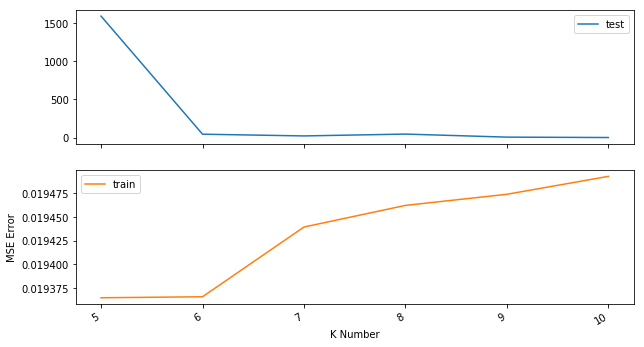

In [85]:
#K-fold varying K number.


#number of folds
#polinomial degree (fixed)
#K
deg = 15
Xm = var_matrix(X,Y,deg)
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list
aver_R2 = []
aver_MSE = []

avtr_R2 = []
avtr_MSE = []

    
for ki in range(5,(10)+1):
    er_R2 = []
    er_MSE = []
    
    tr_R2 = []
    tr_MSE = []
    
    #for checking if by a K number we would have a non equal group, then it should be appended to the last one
    unpair = len(Xm)%ki
    gr = int(len(Xm)/ki)
    
    for k in range(ki):
        #Prepare the test and set trainsa
        rango = list(range(k*gr, gr*(k+1),1))
        X_test = Xm[k*gr: gr*(k+1)]
        Z_test = input_z[k*gr: gr*(k+1)]
        X_train = np.delete(Xm,rango, axis=0)
        Z_train = np.delete(input_z,rango, axis=0)
        
        # in the case it is unpair, last remaining items will be appended (that's right, we maganed the threshold of unpair quantity of elements!)
        if (k == ki-1) and (unpair != 0):
            
            rango = list(range(k*gr, gr*(k+1+unpair),1))
            X_test = Xm[k*gr:]
            Z_test = input_z[k*gr:]
            X_train = np.delete(Xm,rango, axis=0)
            Z_train = np.delete(input_z,rango, axis=0)
        
        #inversion
        inverse = np.linalg.pinv(X_train.T @ X_train)
        #inter = conf_int(inverse, 1.654)
        #interval.append(inter[1] - inter[0])
        beta = inverse @ X_train.T @ Z_train
        #print('Confidence interval for degree', k, '=', inter)
        #predicting the train and test sets
        Z_model = X_test @ beta
        Ztr_model = X_train @ beta
        #adding the performance errors
        tr_R2.append(R2(Z_train, Ztr_model))
        tr_MSE.append(MSE(Z_train, Ztr_model))
        er_R2.append(R2(Z_test,Z_model))
        er_MSE.append(MSE(Z_test,Z_model))
        
    #taking the average over the Kfolds    
    aver_MSE.append(np.mean(er_MSE))
    aver_R2.append(np.mean(er_R2))
    avtr_MSE.append(np.mean(tr_MSE))
    avtr_R2.append(np.mean(tr_R2))
    
#plot
data = pd.DataFrame([aver_MSE, avtr_MSE, list(range(5,(10)+1))]).T.rename(columns={0:'test',1:'train',2:'K'}).set_index('K')
#plt.title('Error for Complexity Degree (Bootstrap) (Scikit-Learn)')
data.plot(subplots=True,figsize=(10,6))
plt.ylabel('MSE Error')
plt.ylabel('MSE Error')
plt.xlabel('K Number')
#plt.title('Error for each K-fold')
plt.savefig('OSL_Kn.png')

<h2>Part D<h2>

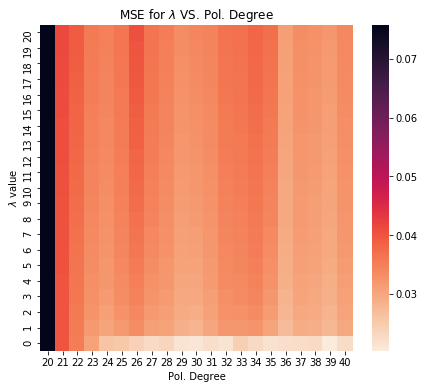

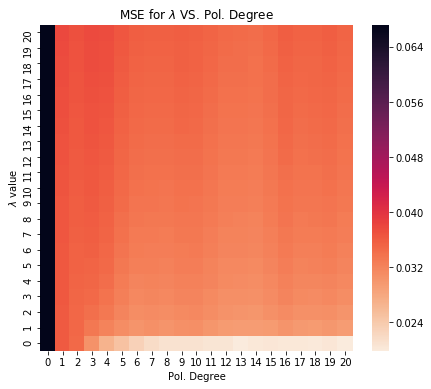

In [9]:
#Ridge Regression
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list
#setting variables to test with the datasets
nlambda = 20
degree = 20

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree+1, nlambda+1))
mer_MSE = np.zeros((degree+1, nlambda+1))
mtr_R2 = np.zeros((degree+1, nlambda+1))
mer_R2 = np.zeros((degree+1, nlambda+1))

for deg in range(degree+1):
    #designing the X matrix and data plit for train and test
    Xm = var_matrix(X,Y,deg)
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size=0.2)
    

    for l in range(nlambda+1):
        #inversion by adding the lambda parameter with an identity matrix (operates only in the diagonal components)
        mult = X_train.T @ X_train    
        inverse = np.linalg.pinv(mult + l*np.eye(len(mult)))
        beta = inverse @ X_train.T @ Z_train
        #prediction with train and test sets
        Z_model = X_test @ beta
        Ztr_model = X_train @ beta
        
        #adding the performance erros into matrix for the later heatmap plot

        mtr_R2[deg,l] = R2(Z_train, Ztr_model)
        mtr_MSE[deg,l] = MSE(Z_train, Ztr_model)
        mer_R2[deg,l] = R2(Z_test,Z_model)
        mer_MSE[deg,l] = MSE(Z_test,Z_model)

#just setting the size
largo, alto = 7, 6
#plot for test
plt.figure(figsize=(largo, alto))
ax = sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
ax.set_xticklabels(np.arange(20,40+1))
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Ridge_simple_test.png')


#plot for train
plt.figure(figsize=(largo, alto))
sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Ridge_simple_train.png')

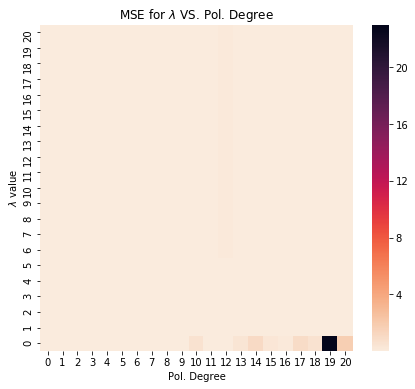

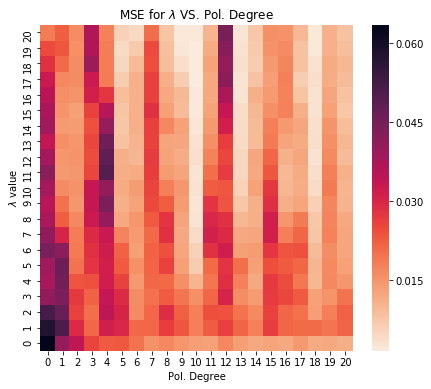

In [61]:
#Ridge Regression with Bootstrap
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list

nlambda = 20
degree = 20
boot = 20

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree+1, nlambda+1))
mer_MSE = np.zeros((degree+1, nlambda+1))
mtr_R2 = np.zeros((degree+1, nlambda+1))
mer_R2 = np.zeros((degree+1, nlambda+1))

for deg in range(degree+1):
    
    #Designing the X matrix and random test train split
    Xm = var_matrix(X,Y,deg)
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size=0.2)
    

    for l in range(nlambda+1):
        #this time we were efficient in terms of memory. We corected the mistake... YEI!
        er_MSE = 0
        tr_MSE = 0
        er_R2 = 0
        tr_R2 = 0
        
        for B in range(boot):
        #Takes random data for Train from the already Train dataset. Part of the data could be picked twice.
            numers  = np.random.randint(0,len(X_train),len(X_train))
            X_train = X_train[numers]
            Z_train = Z_train[numers]
            mult = X_train.T @ X_train
            #inversion part with the new lambda parameter as diagonal 
            inverse = np.linalg.pinv(mult + l*np.eye(len(mult)))
            beta = inverse @ X_train.T @ Z_train
            Z_model = X_test @ beta
            Ztr_model = X_train @ beta
            #adding the bootstrapped values to the total error
            tr_R2 += R2(Z_train, Ztr_model)
            tr_MSE += MSE(Z_train, Ztr_model)
            er_R2 += R2(Z_test,Z_model)
            er_MSE += MSE(Z_test,Z_model)

        #averaging the values of the errors for boootstrap
        mtr_R2[deg,l] = tr_R2/boot
        mtr_MSE[deg,l] =  tr_MSE/boot
        mer_R2[deg,l] = er_R2/boot
        mer_MSE[deg,l] =  er_MSE/boot

#mer_MSE = mer_MSE[1:]
#figures size parameters
largo, alto = 7, 6
#plot for test
plt.figure(figsize=(largo, alto))
sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Ridge_boot_test.png')

#plot for train
plt.figure(figsize=(largo, alto))
sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Ridge_boot_train.png')

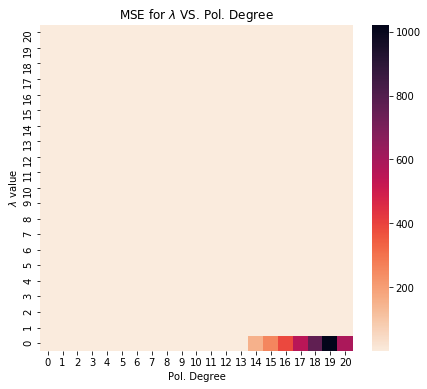

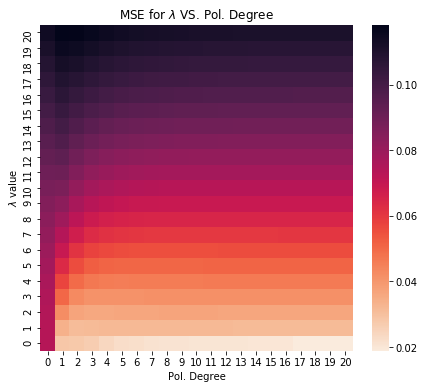

In [64]:
#Ridge Regression with K-Fold
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list
#initial values for parameters variation
nlambda = 20
degree = 20
K = 10

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree+1, nlambda+1))
mer_MSE = np.zeros((degree+1, nlambda+1))
mtr_R2 = np.zeros((degree+1, nlambda+1))
mer_R2 = np.zeros((degree+1, nlambda+1))

for deg in range(degree+1):
    
    #designin the X matrix
    Xm = var_matrix(X,Y,deg)    

    for l in range(nlambda+1):
        
        er_MSE = 0
        tr_MSE = 0
        er_R2 = 0
        tr_R2 = 0
        
        #function of scikit learn to do the cross-validaiton
        kf = KFold(n_splits=K)
        
        #loop for all the K_folds using scikit learn
        for train_index, test_index in kf.split(X):
        #Takes random data for Train from the already Train dataset. Part of the data could be picked twice.
            X_train, X_test, Z_train, Z_test = Xm[train_index], Xm[test_index], input_z[train_index], input_z[test_index]
            mult = X_train.T @ X_train    
            #linear inversion with the penalty parameter operating in the diagoonal elements
            inverse = np.linalg.pinv(mult + l*np.eye(len(mult)))
            beta = inverse @ X_train.T @ Z_train
            #prediction values for train an test set
            Z_model = X_test @ beta
            Ztr_model = X_train @ beta
            #acumulating the errors
            tr_R2 += R2(Z_train, Ztr_model)
            tr_MSE += MSE(Z_train, Ztr_model)
            er_R2 += R2(Z_test,Z_model)
            er_MSE += MSE(Z_test,Z_model)

        #averaging the value sofr the K-Fold
        mtr_R2[deg,l] = tr_R2/K
        mtr_MSE[deg,l] =  tr_MSE/K
        mer_R2[deg,l] = er_R2/K
        mer_MSE[deg,l] =  er_MSE/K

#mer_MSE = mer_MSE[1:]

#figure size parameters
largo, alto = 7, 6
#plot the test error
plt.figure(figsize=(largo, alto))
sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Ridge_Kfold10_test.png')

#plot the train error
plt.figure(figsize=(largo, alto))
sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Ridge_Kfold10_train.png')

<h2>Part E<h2>

/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


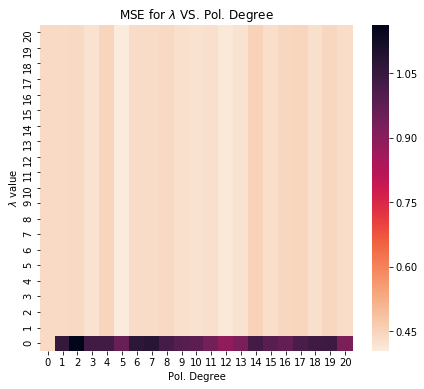

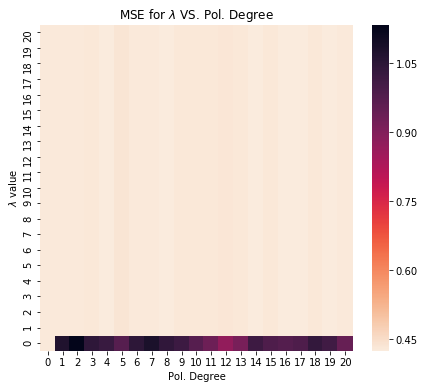

In [77]:
#Lasso Regression
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list
#maximum variability for the complexity and the lambda values
nlambda = 20
degree = 20

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree+1, nlambda+1))
mer_MSE = np.zeros((degree+1, nlambda+1))
mtr_R2 = np.zeros((degree+1, nlambda+1))
mer_R2 = np.zeros((degree+1, nlambda+1))

for deg in range(degree+1):
    #designing the Xmatrix and train test split
    Xm = var_matrix(X,Y,deg)
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size=0.2)

    for l in range(nlambda+1):
        #Lasso with the scikit learn method
        reg = Lasso(alpha=l).fit(X_train,Z_train)
        beta = reg.coef_
        #prediction with test and train sets
        Z_model = X_test @ beta
        Ztr_model = X_train @ beta
        #addidn the error into the matrix for further heatmap plotting
        mtr_R2[deg,l] = R2(Z_train, Ztr_model)
        mtr_MSE[deg,l] =  MSE(Z_train, Ztr_model)
        mer_R2[deg,l] = R2(Z_test,Z_model)
        mer_MSE[deg,l] =  MSE(Z_test,Z_model)


#mer_MSE = mer_MSE[:,1:]
#mtr_MSE = mtr_MSE[:,1:]

#figure size parameters
largo, alto = 7, 6
#plot test  set
plt.figure(figsize=(largo, alto))
sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Lasso_simple_test.png')

#plot train set
plt.figure(figsize=(largo, alto))
sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Lasso_simple_train.png')

/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


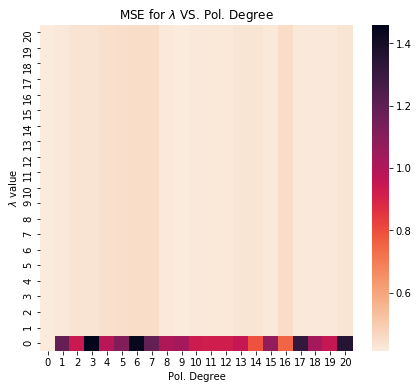

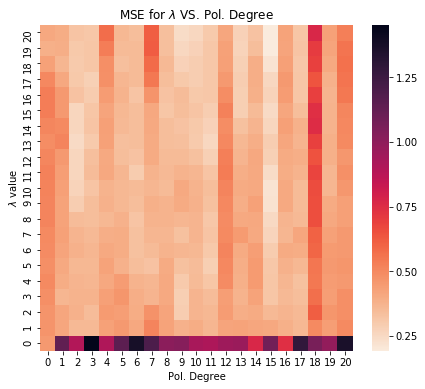

In [66]:
#Lasso Regression with Bootstrap
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list
#initial maximum parameters to vary
nlambda = 20
degree = 20
boot = 20

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree+1, nlambda+1))
mer_MSE = np.zeros((degree+1, nlambda+1))
mtr_R2 = np.zeros((degree+1, nlambda+1))
mer_R2 = np.zeros((degree+1, nlambda+1))

for deg in range(degree+1):
    #designing the X matrix and data set split
    Xm = var_matrix(X,Y,deg)
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, input_z, test_size=0.2)

    for l in range(nlambda+1):
        
        er_MSE = 0
        tr_MSE = 0
        er_R2 = 0
        tr_R2 = 0
        
        for B in range(boot):
        #Takes random data for Train from the already Train dataset. Part of the data could be picked twice.
            numers  = np.random.randint(0,len(X_train),len(X_train))
            X_train = X_train[numers]
            Z_train = Z_train[numers]
            #Lasso regression with scikit learn method
            reg = Lasso(alpha=l).fit(X_train,Z_train)
            beta = reg.coef_
            #train and test predictions
            Z_model = X_test @ beta
            Ztr_model = X_train @ beta
            #adding the errors
            tr_R2 += R2(Z_train, Ztr_model)
            tr_MSE += MSE(Z_train, Ztr_model)
            er_R2 += R2(Z_test,Z_model)
            er_MSE += MSE(Z_test,Z_model)
            
        #Averaging the errors of bootstrap
        mtr_R2[deg,l] = tr_R2/boot
        mtr_MSE[deg,l] =  tr_MSE/boot
        mer_R2[deg,l] = er_R2/boot
        mer_MSE[deg,l] =  er_MSE/boot


#mer_MSE = mer_MSE[:,1:]
#figure size parameters
largo, alto = 7, 6
#plot for test set
plt.figure(figsize=(largo, alto))
sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Lasso_boot_test.png')

#plot for train set
plt.figure(figsize=(largo, alto))
sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Lasso_boot_train.png')

/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


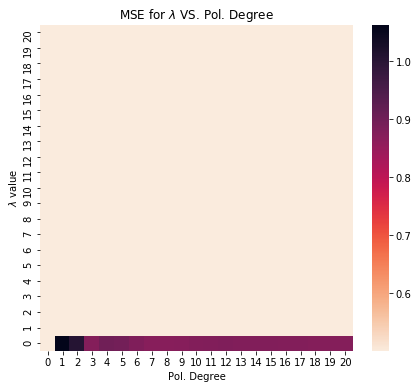

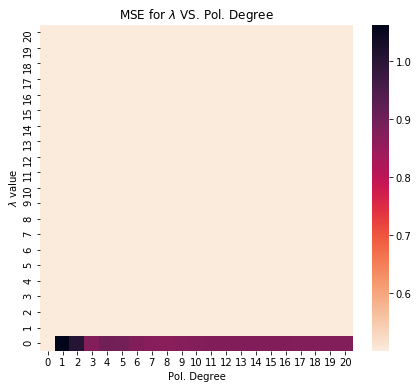

In [73]:
#Lasso Regression with K-Fold
input_z = Z.reshape(Z.shape[0]*Z.shape[1])
#Error values list
#maximum variables to vary
nlambda = 20
degree = 20
K = 50

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree+1, nlambda+1))
mer_MSE = np.zeros((degree+1, nlambda+1))
mtr_R2 = np.zeros((degree+1, nlambda+1))
mer_R2 = np.zeros((degree+1, nlambda+1))

for deg in range(degree+1):
    #designing the X matrix
    Xm = var_matrix(X,Y,deg)

    for l in range(nlambda+1):
        
        er_MSE = 0
        tr_MSE = 0
        er_R2 = 0
        tr_R2 = 0
        #defining the splitting of the KFold with Scikit-Learn
        kf = KFold(n_splits=K)
        
        #loop for all the K_folds
        for train_index, test_index in kf.split(X):
        #Takes random data for Train from the already Train dataset. Part of the data could be picked twice.
            X_train, X_test, Z_train, Z_test = Xm[train_index], Xm[test_index], input_z[train_index], input_z[test_index]
            #doing the inversion with Scikit Learn
            reg = Lasso(alpha=l).fit(X_train,Z_train)
            beta = reg.coef_
            #train and test predicitons
            Z_model = X_test @ beta
            Ztr_model = X_train @ beta
            #acumuylating the errors per each KFolding
            tr_R2 += R2(Z_train, Ztr_model)
            tr_MSE += MSE(Z_train, Ztr_model)
            er_R2 += R2(Z_test,Z_model)
            er_MSE += MSE(Z_test,Z_model)

        #averaging the errors
        mtr_R2[deg,l] = tr_R2/K
        mtr_MSE[deg,l] =  tr_MSE/K
        mer_R2[deg,l] = er_R2/K
        mer_MSE[deg,l] =  er_MSE/K

#Figure size parameters
largo, alto = 7, 6
#plot for test set
plt.figure(figsize=(largo, alto))
sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Lasso_Kfold50_test.png')

#plot for train set
plt.figure(figsize=(largo, alto))
sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('Lasso_Kfold50_train.png')